<a href="https://colab.research.google.com/github/sahug/time-series/blob/main/TSA%20-%20XGBoost%20-%20Web%20Traffic%20Time%20Series%20Forecasting..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TSA - XGBoost - Web Traffic Time Series Forecasting**

**Get Dataset**

In [5]:
!pip install -qq statsmodels --upgrade

In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c web-traffic-time-series-forecasting

 97% 568M/583M [00:06<00:00, 122MB/s]
100% 583M/583M [00:06<00:00, 98.5MB/s]


**Unzip**

In [8]:
import zipfile
with zipfile.ZipFile("/content/web-traffic-time-series-forecasting.zip", "r") as zip:
  zip.extractall("/content/")

In [9]:
with zipfile.ZipFile("/content/train_1.csv.zip", "r") as zip:
  zip.extractall("/content/")

**Load Dataset**

In [10]:
import pandas as pd

In [11]:
train = pd.read_csv("/content/train_1.csv")

In [12]:
print(train.shape)
train.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [13]:
ds = train.copy()

**Extract Name and Language**

In [14]:
name = []
for page in ds['Page']:
    split = page.split('.')
    name.append(split[-3])

ds['Name'] = name
ds['Language'] = ds['Name'].str[-2:]

In [15]:
ds.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Name,Language
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,2NE1_zh,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,2PM_zh,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,3C_zh,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,4minute_zh,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You_zh,zh


**Languages**

In [16]:
languages = ds['Language'].unique()
languages

array(['zh', 'fr', 'en', 'ns', 'ru', 'ww', 'de', 'ja', 'es'], dtype=object)

**Stationary Test**

**Augmented Dickey-Fuller Test**

ADF Test for each of the different pages and languages.

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [18]:
def stationarity_test(timeseries, rolling_window, language):
    plt.figure(figsize=(25, 8))
    
    rolling_mean = pd.DataFrame.rolling(timeseries, window=rolling_window).mean()
    rolling_std = pd.DataFrame.rolling(timeseries, window=rolling_window).std()

    plt.plot(timeseries, color='blue', label= 'Original')
    plt.legend(loc='best')
    
    plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    plt.legend(loc='best')
    
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    
    plt.title(f'Rolling Mean & Standard Deviation by Language : {language}')
    plt.show()
    
    # ADF Test
    print('Results of ADF Test')
    print()
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    print('-'*100)

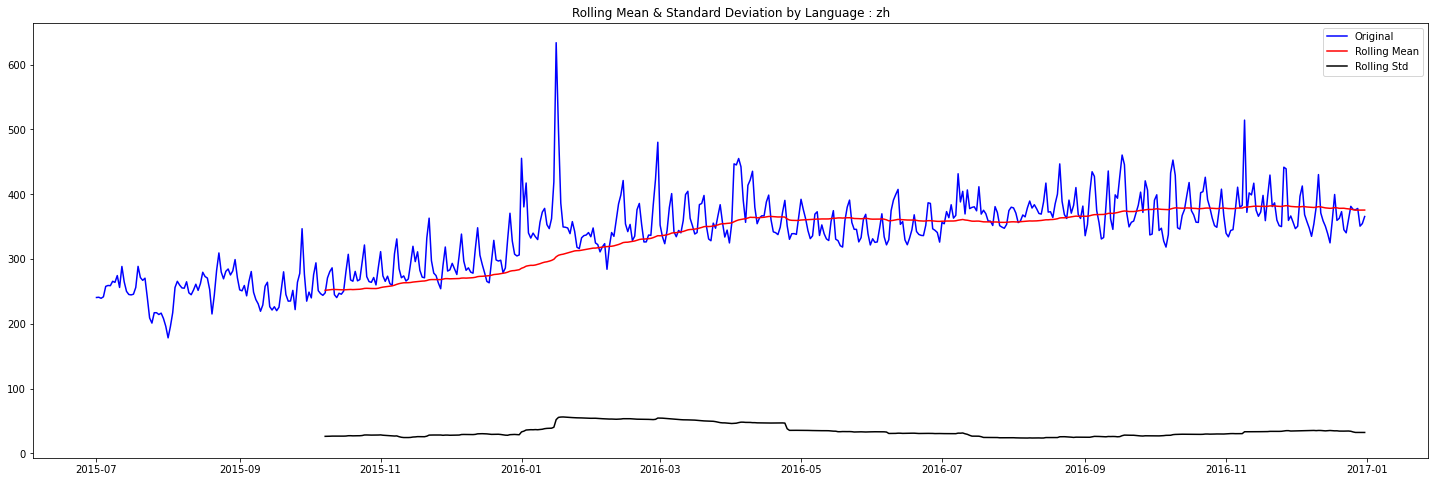

Results of ADF Test

Test Statistic                  -1.668433
p-value                          0.447446
#Lags Used                      19.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64
----------------------------------------------------------------------------------------------------


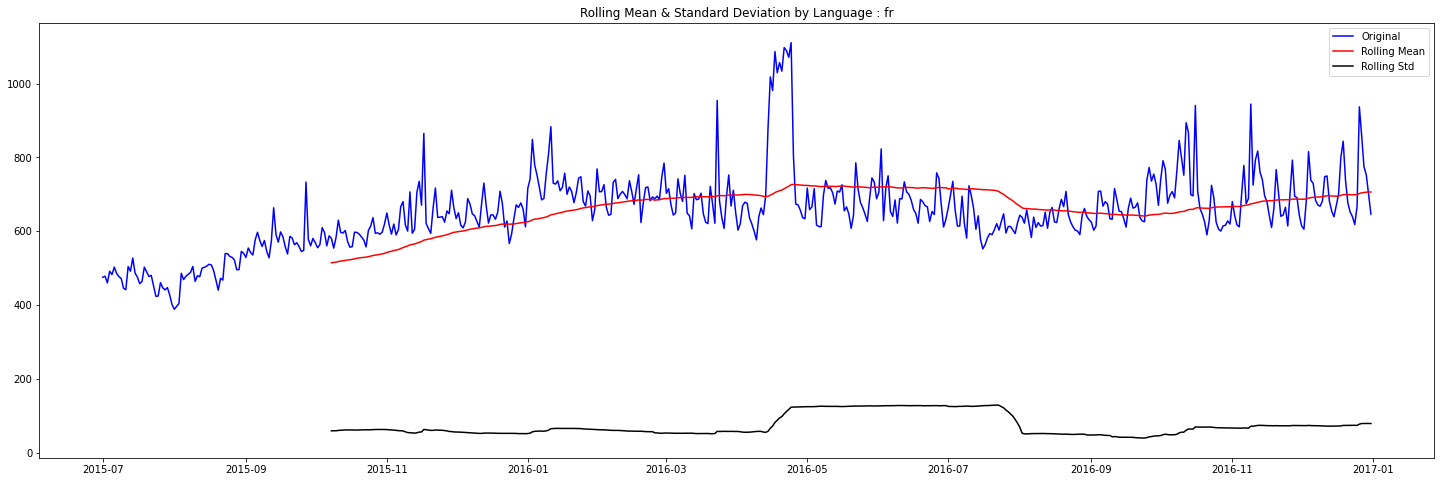

Results of ADF Test

Test Statistic                  -2.849875
p-value                          0.051495
#Lags Used                      13.000000
Number of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64
----------------------------------------------------------------------------------------------------


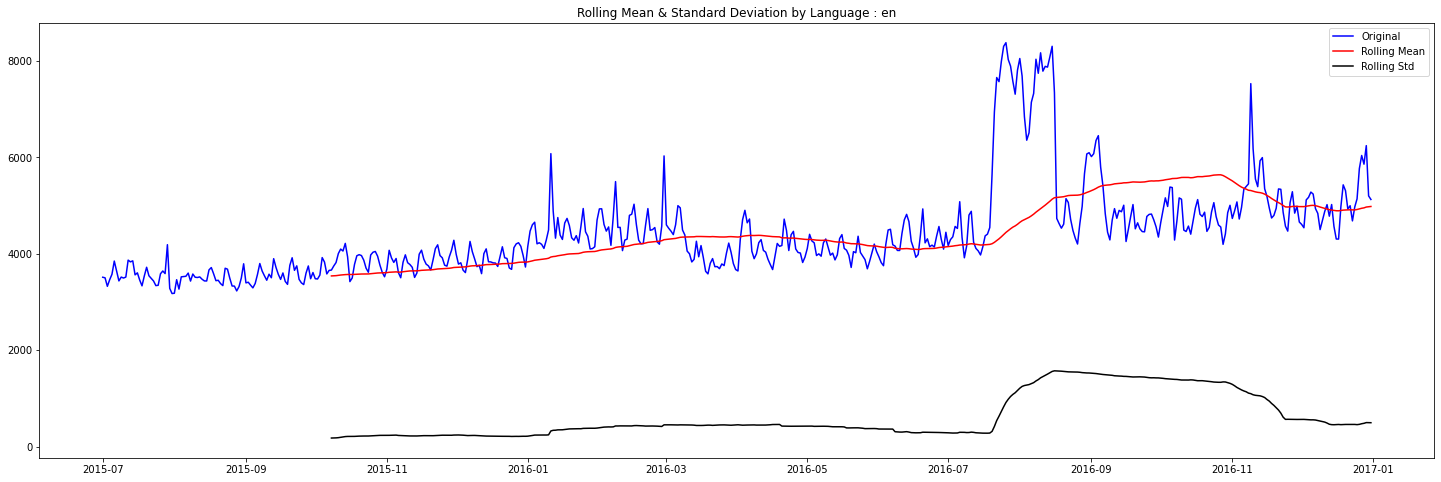

Results of ADF Test

Test Statistic                  -2.247284
p-value                          0.189534
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64
----------------------------------------------------------------------------------------------------


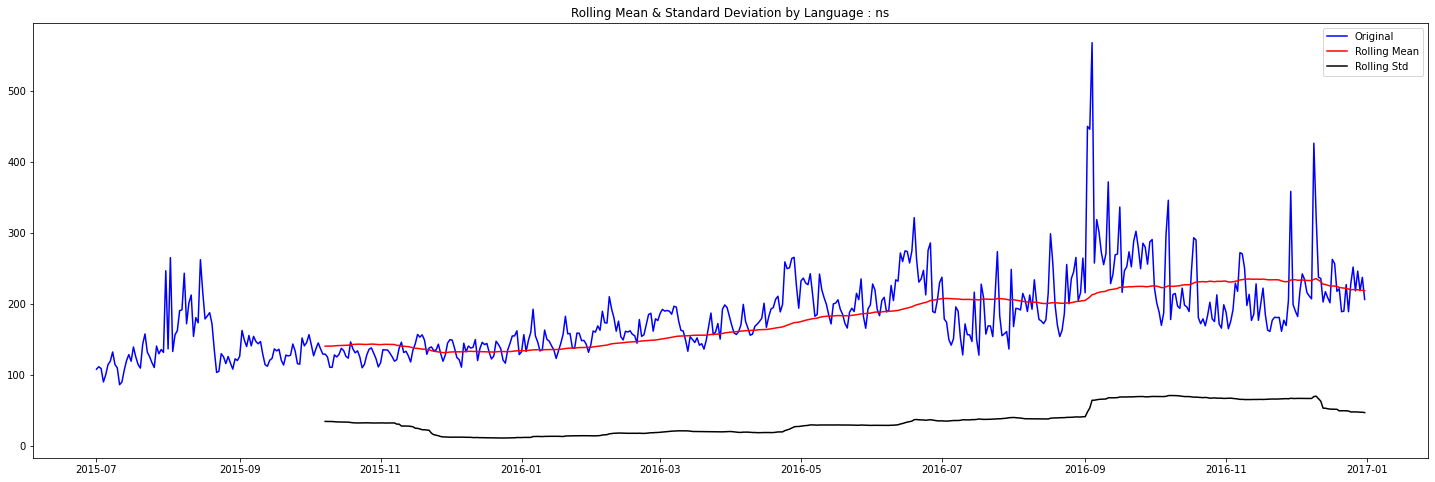

Results of ADF Test

Test Statistic                  -2.840219
p-value                          0.052754
#Lags Used                       6.000000
Number of Observations Used    543.000000
Critical Value (1%)             -3.442450
Critical Value (5%)             -2.866877
Critical Value (10%)            -2.569613
dtype: float64
----------------------------------------------------------------------------------------------------


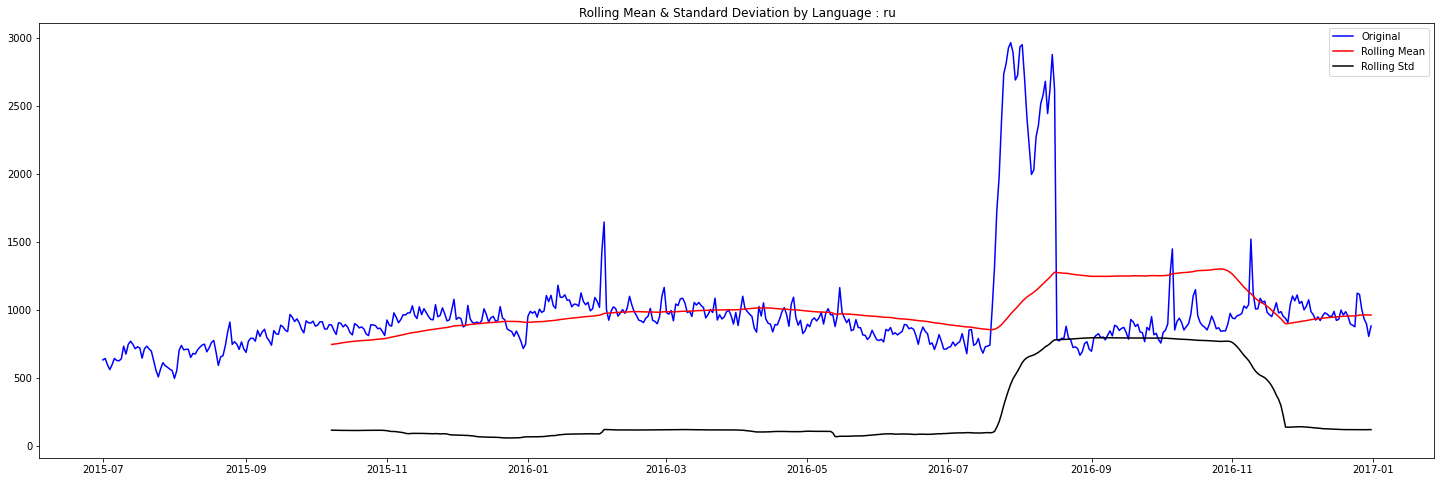

Results of ADF Test

Test Statistic                  -3.924031
p-value                          0.001865
#Lags Used                       3.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64
----------------------------------------------------------------------------------------------------


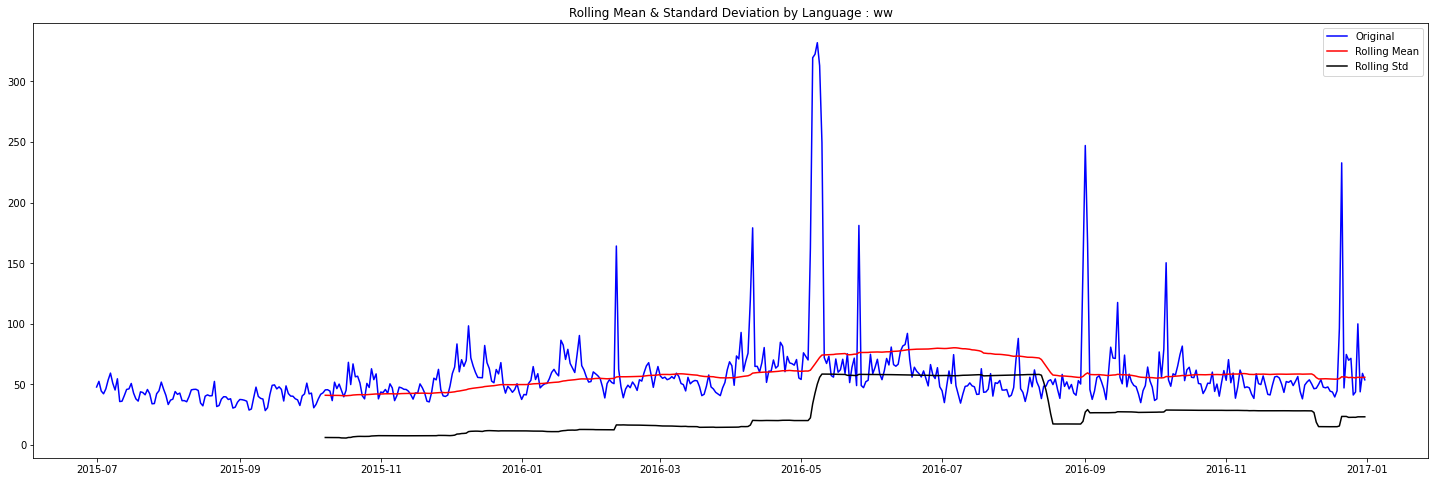

Results of ADF Test

Test Statistic                -6.338871e+00
p-value                        2.786556e-08
#Lags Used                     7.000000e+00
Number of Observations Used    5.420000e+02
Critical Value (1%)           -3.442473e+00
Critical Value (5%)           -2.866887e+00
Critical Value (10%)          -2.569618e+00
dtype: float64
----------------------------------------------------------------------------------------------------


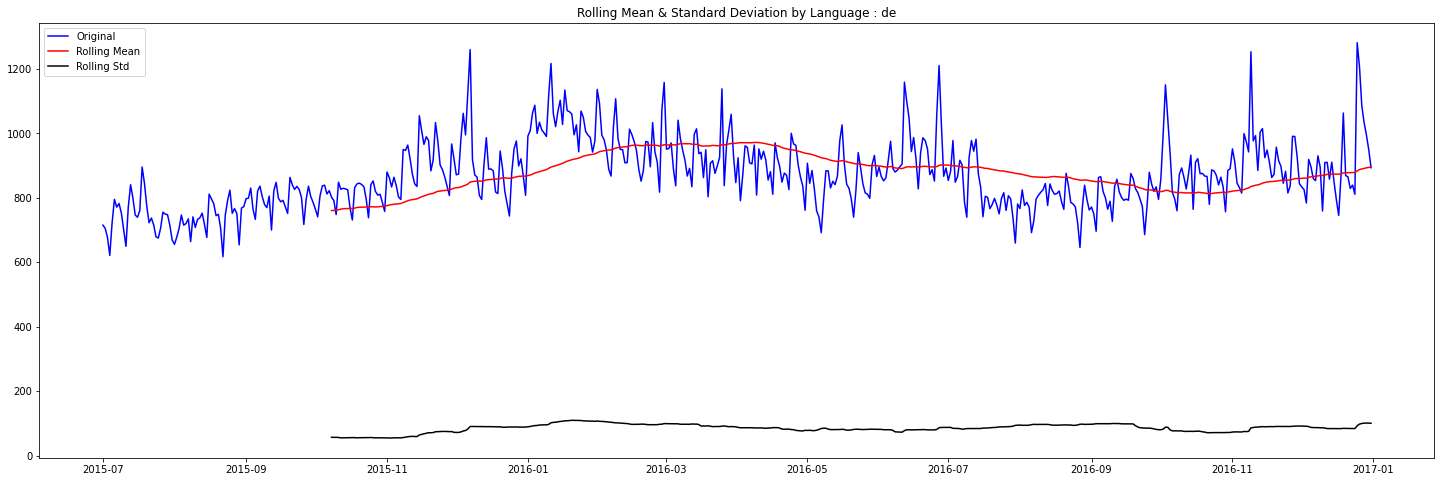

Results of ADF Test

Test Statistic                  -2.402707
p-value                          0.140974
#Lags Used                      16.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64
----------------------------------------------------------------------------------------------------


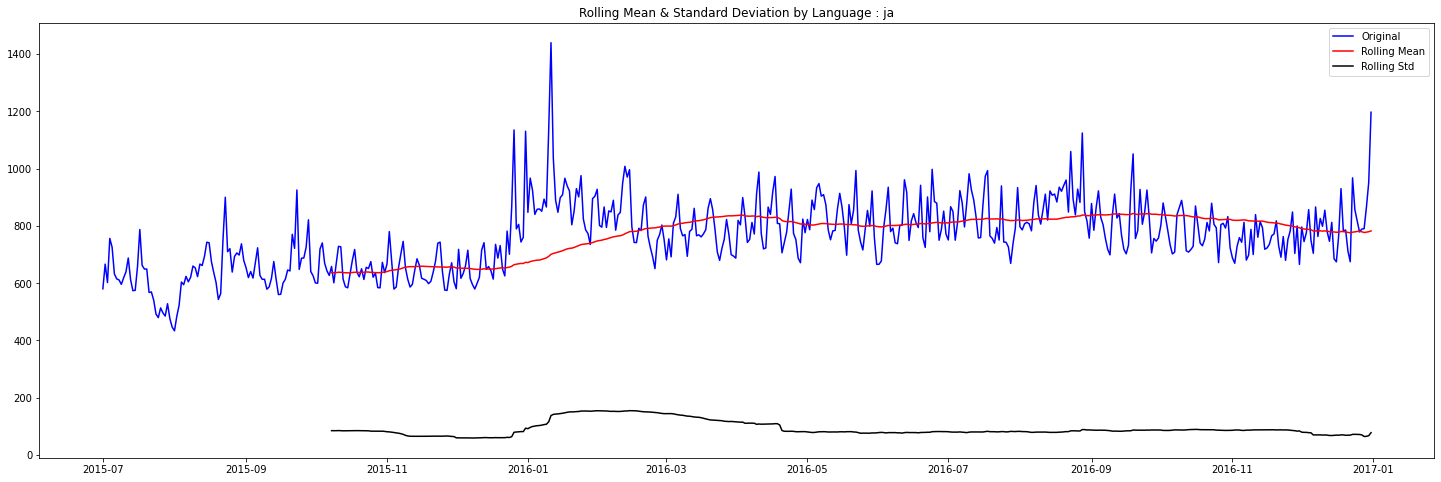

Results of ADF Test

Test Statistic                  -2.555394
p-value                          0.102571
#Lags Used                       8.000000
Number of Observations Used    541.000000
Critical Value (1%)             -3.442495
Critical Value (5%)             -2.866897
Critical Value (10%)            -2.569623
dtype: float64
----------------------------------------------------------------------------------------------------


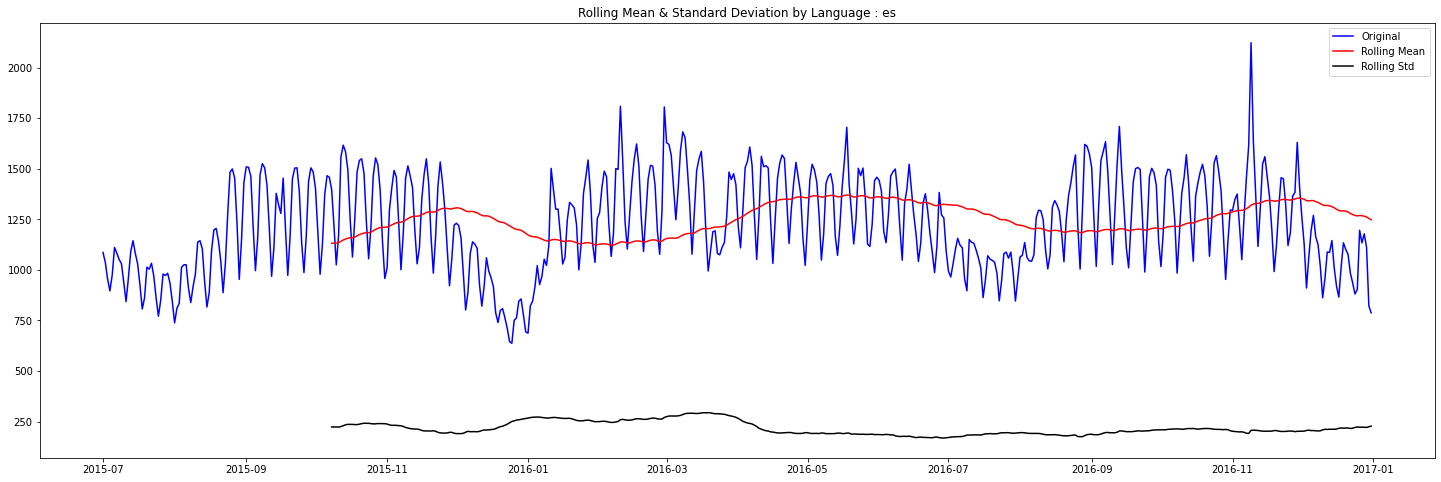

Results of ADF Test

Test Statistic                  -3.014209
p-value                          0.033589
#Lags Used                      15.000000
Number of Observations Used    534.000000
Critical Value (1%)             -3.442655
Critical Value (5%)             -2.866968
Critical Value (10%)            -2.569661
dtype: float64
----------------------------------------------------------------------------------------------------


In [19]:
for lang in languages:
    
    df = ds[ds['Language'] == lang]
    
    remove_col = ['Language', 'Name']
    pv = df.drop(remove_col, axis=1)
    
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot['Date'] = pd.to_datetime(pivot['Date'])
    pivot.fillna(0, inplace=True)
    
    group_by = pivot[['Date', 'Visits', 'Page']].groupby(['Date'])['Visits'].mean()
    
    stationarity_test(group_by, rolling_window=100, language=lang)

*From the above graph we can conlude that the p-value of **zh, en, ja** is greater than 5% which means that the data is non-stationary, whereas the p-value for other languages is less than 5%, that means they are stationary.*

**Melt Dataset**
- Column1: Page
- Column2: Date
- Column3: Value

In [20]:
ds = ds.drop(['Name', 'Language'], axis=1)
ds = ds.melt(id_vars="Page", var_name="Date", value_name="Visits")
ds.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN


**Null Values**

In [21]:
ds.isna().sum()

Page            0
Date            0
Visits    6192931
dtype: int64

In [22]:
ds.fillna(0, inplace=True)

In [23]:
ds.isna().sum()

Page      0
Date      0
Visits    0
dtype: int64

**Auto Correlation and Partial Correlation**

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
acf = ds[["Date", "Visits"]].groupby(["Date"])["Visits"].mean()

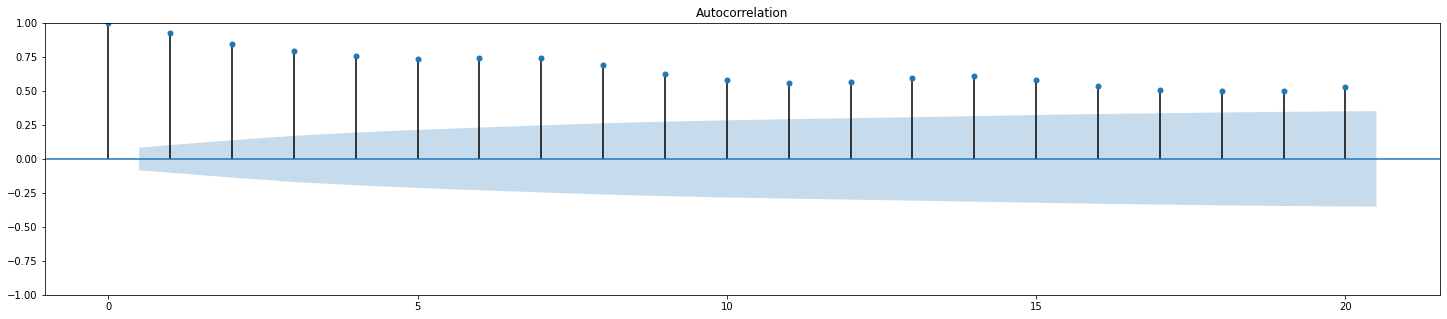

In [26]:
fig = plot_acf(acf, lags=20)
fig.set_size_inches(25, 5)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


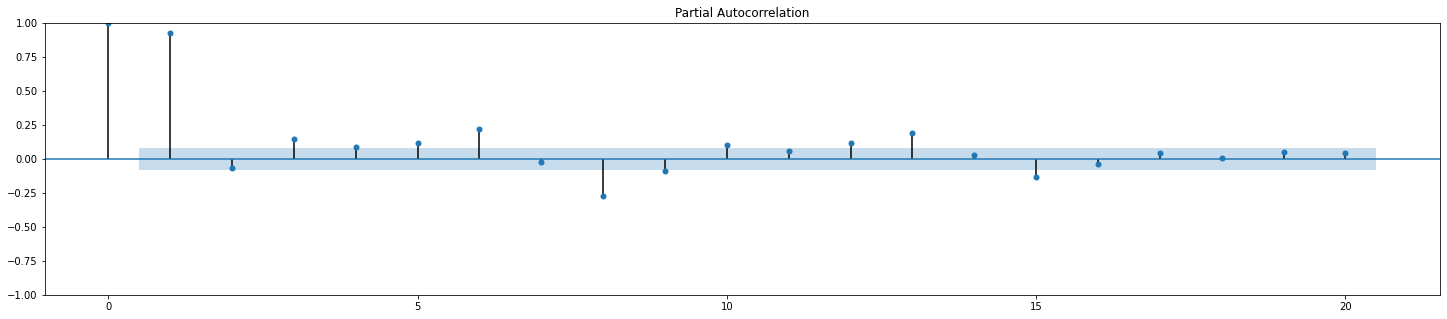

In [27]:
fig = plot_pacf(acf, lags=20)
fig.set_size_inches(25, 5)
plt.show()

*We can see that there is geometric decrease in acf lags and sudden decrease in pacf after 2 lags.*

**Building and Testing Models**

In [28]:
data = train.copy()
data = data.drop(["Page"], axis=1)
data.fillna(0, inplace=True)

**SMAPE Metric**

In [29]:
import numpy as np

In [30]:
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

In [31]:
def plot_predictions(actual, predicted, figsize, title):    
    plt.figure(figsize=figsize)
    actual = plt.plot(actual, color='blue', label='Actual')
    predicted = plt.plot(predicted, color='red', label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

**ARIMA Model**

In [76]:
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

In [79]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [84]:
def xgboost(data, estimators, visualize_predictions):
    
    # Split into training and testing
    train = data[:-31].values
    test = data[-31:].values
    
    x_train, y_train = create_dataset(train.reshape(-1, 1))
    x_test, y_test = create_dataset(test.reshape(-1, 1))
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    train_error = smape(y_train, train_pred)
    test_error = smape(y_test, test_pred)
    
    if visualize_predictions:
        plot_predictions(y_train, train_pred, figsize=(25, 4), title='Training Predictions')
        plot_predictions(y_test, test_pred, figsize=(25, 4), title='Testing Predictions')
    
    print("\n")
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

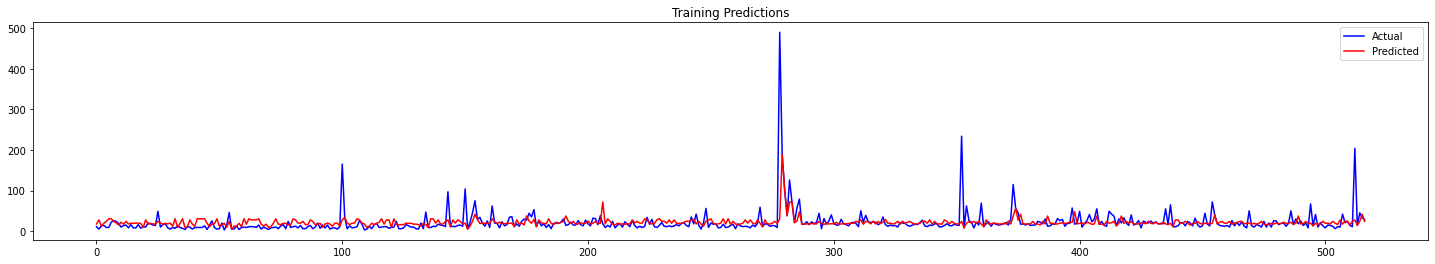

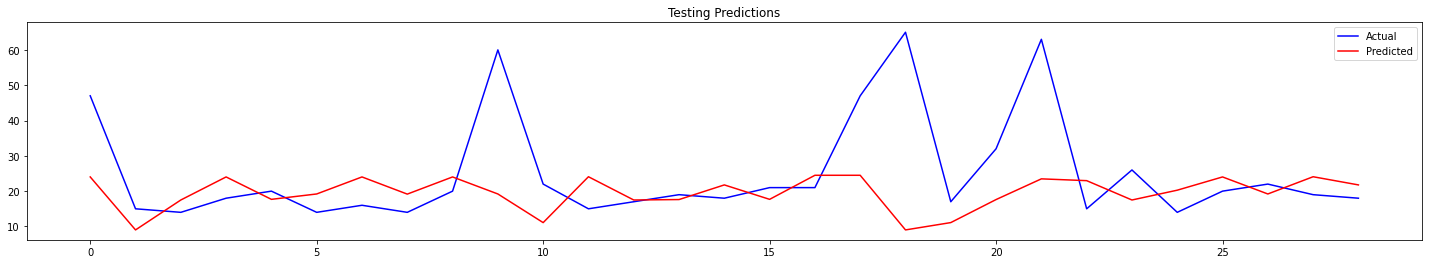



Train Error: 47.37777017733616 | Test Error: 40.46637742188864


In [85]:
train = data.iloc[0, :]
model = xgboost(train, 2000, True)